## Analysis of blood glucose data to assess the reproducibility of the post-prandial blood glucose response (PPGR)
### Process the raw blood glucose data to generate 'glucose events' (initail nadir / peak / secondary nadir)

1. Preprocess the raw data
2. Seasonality : 4 hour window periods
3. Standard deviation for 4 hour periods
4. Timestamps matched for carbohydrate intake (i.e. all 35g CHO within 1 hour of eachother grouped together)
5. Rate of glucose appearance and disappearance<br>
    *a. Glucose excursion (nadir to peak / peak to nadir) - +ve and -ve trends*<br>
    *b. iAUC (nadir to peak / peak to nadir) - +ve and -ve trends*
6. Total change in BG (nadir to peak / peak to nadir) - +ve and -ve 
7. Incude the Carbs consumed in the 4 hour period
8. Collate the results of the above points into a data set with columns names:
    * Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)  
    * Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
    * Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
    * Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
    * Time period Number (1 / 2 / 3 / 4 / 5)
    * iAUC (+ve)
    * iAUC (-ve)
    * ROA / Glucose Excursion (+ve)
    * ROD / Glucose Excursion (-ve)
    * Total change in BG (+ve)
    * Total change in BG (-ve)
    * Peak value
    * Carbs
9. Generate a DataFrame of the glucose event parameters

### 'Cluster' or group the glucose events accoridng to clinically relevant parameters
1. 'Cluster' the glucose events based on the following set of rules
    * Rate of glucose appearance (ROA) / 
    * positive_iAUC (initial_nadir to peak)
    * Rate of gluocse dissapearance (ROD)
    * negative_iAUC (peak to second_nadir)
    * Elapsed time between initial_nadir and secondary_nadir points (time_lapse)
    * Carb intake in time frame

### Review the appropriatness of the 'clustering' or grouping
1. Goodness of fit assessment :
    * Want the algorithm to be adaptive.
    * Have the left overs recycled through the 'rules' missing the glucose excursion but maintaining the iAUC and total change in BG.
    * Then further iterations miss out the iAUC and review total change in BG etc

### Import/load necessary libraries 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
from datetime import timedelta
from statistics import mode
from scipy.signal import find_peaks

%matplotlib inline

### Load and preprocess necessary data sets

In [27]:
def read_data(filename):
    unfiltered = pd.read_csv(os.path.join("CSV Files", filename))
    unfiltered['glucose_level_ts'] = pd.to_datetime(unfiltered['glucose_level_ts'], dayfirst=True)
    unfiltered.drop('glucose_level_mmol/L', axis=1, inplace=True)
    return unfiltered

In [28]:
def slice_data(data, time_step, n_samples):
    timestamp = np.array(data['glucose_level_ts'], dtype=float)
    glucose = np.array(data['glucose_level_mg/dL'], dtype=float)
    n_samples_per_segment = int(time_step / timedelta(minutes=1)) * n_samples
    glucose_seg_ts = [timestamp[i:i + n_samples_per_segment] for i in range(0, len(data), n_samples_per_segment)]
    glucose_sliced = [glucose[i:i + n_samples_per_segment] for i in range(0, len(data), n_samples_per_segment)]
    return glucose_sliced, glucose_seg_ts

In [29]:
unfiltered = read_data('540_data.csv')

In [30]:
# Select glucose level and timestamp features
features = ['glucose_level_ts', 'glucose_level_mg/dL']
data = unfiltered[features].copy()

# Map day of week names to day of week numbers
data['day_of_week'] = data['glucose_level_ts'].dt.dayofweek
data['day_of_week_name'] = data['glucose_level_ts'].dt.day_name()

# Set time step in minutes
time_step = data['glucose_level_ts'].diff().mode()[0] / timedelta(minutes=1)

# Calculate rate of change
data['bg_rate_of_change'] = data['glucose_level_mg/dL'].diff() / time_step

In [31]:
prominence = 18 

elements_per_6hours = 72  # 72 BG samples in 6 hours sample

### Isolate the peak and nadir (low) points in the set windows

In [32]:
# sliced data set into 4 hour segments

timestamp = data['glucose_level_ts'].to_numpy('datetime64')
glucose = data['glucose_level_mg/dL'].to_numpy('float32')

elements_per_6hours = 72  # 72 BG samples in 6 hours sample
glucose_seg_ts = [timestamp[i:i+elements_per_6hours] for i in range(0, len(data), elements_per_6hours)]
glucose_sliced = [glucose[i:i+elements_per_6hours] for i in range(0, len(data), elements_per_6hours)]

glucose_segment = glucose_sliced[1] #selecting the 3rd segment, for example
glucose_segment_ts = glucose_seg_ts[1] 

print("Length of glucose segment:", len(glucose_segment))

# # find peaks and troughs
# peaks, _ = find_peaks(glucose_segment)
# troughs, _ = find_peaks(-glucose_segment)

# # Print peaks and troughs
# print("Peaks: ", peaks)
# print("Troughs: ", troughs)

# # Check the length of the peaks and troughs lists
# print("Length of peaks:", len(peaks))
# print("Length of troughs:", len(troughs))

Length of glucose segment: 72


In [33]:
def split_df(df, chunk_size): 
    num_chunks = len(df) // chunk_size + 1
    chunks = [df[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]
    return chunks

In [34]:
glucose_ts_sliced = split_df(data['glucose_level_ts'], chunk_size=elements_per_6hours)
glucose_value_sliced = split_df(data['glucose_level_mg/dL'], chunk_size=elements_per_6hours)
glucose_ts_sliced_ = glucose_ts_sliced[1]
glucose_value_sliced_ = glucose_value_sliced[1]

In [35]:
(peaks, _), (troughs, _) = map(find_peaks, [glucose_value_sliced_, -glucose_value_sliced_])

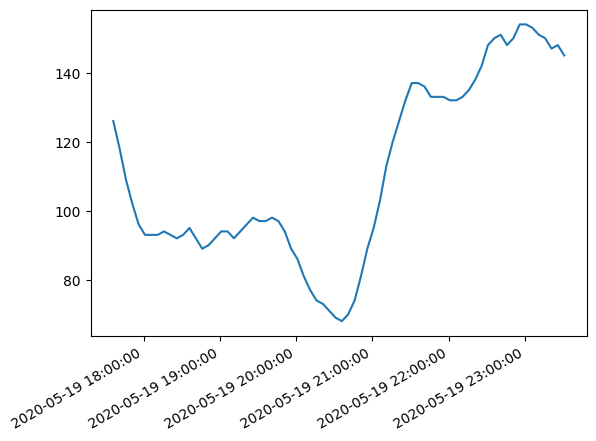

In [36]:
import matplotlib.dates as mdates

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(glucose_ts_sliced_, glucose_value_sliced_)
fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(fmt)
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')

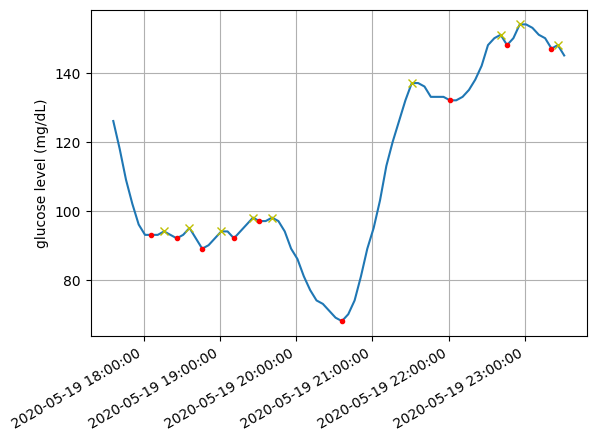

In [37]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.grid()

ax1.plot(glucose_ts_sliced_, glucose_value_sliced_)
ax1.plot(glucose_ts_sliced_.iloc[peaks], glucose_value_sliced_.iloc[peaks], "yx")
ax1.plot(glucose_ts_sliced_.iloc[troughs], glucose_value_sliced_.iloc[troughs], "r.")
ax1.set_ylabel('glucose level (mg/dL)')

fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax1.xaxis.set_major_formatter(fmt)
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')

### Isolate the Glucose Events (initial low, peak and secondary low)

In [38]:
max_nadir_to_peak_time, max_peak_to_2nd_nadir_time, max_peak_to_peak_time = map(
    lambda x: datetime.timedelta(hours=x), [2, 4, 6])

In [39]:
# Set time threshold values for glycemic events
max_nadir_to_peak_time = timedelta(hours=2)
max_peak_to_2nd_nadir_time = timedelta(hours=4)
max_peak_to_peak_time = timedelta(hours=6)

events = []
for i in range(len(glucose_sliced)):
    glucose_segment = glucose_sliced[i]
    glucose_segment_ts = glucose_seg_ts[i]

    # find peaks and troughs
    peaks, _ = find_peaks(glucose_segment)
    troughs, _ = find_peaks(-glucose_segment)

    VERBOSE = False #False # set to True for parameter tuning/debugging

    if len(troughs) == 0:
        continue  # No troughs found, skip to the next iteration

    # Ignore peaks that appear before any nadirs, or that have no (secondary) nadir afterwards
    ignored_peaks = (peaks < troughs[0]) | (peaks > troughs[-1])  

    counter =0
    # Loop through all peaks
    for j, idx in enumerate(peaks):
        
        if ignored_peaks[j]: 
            if VERBOSE: print(f"peak #{j} ({idx}) ignored")        
            continue    
        
        # Find the last nadir event that occurred before the peak event
        last_nadir_idx = troughs[ np.flatnonzero(troughs < idx)[-1] ]  
        print(last_nadir_idx)

        # check that event occurred within the time threshold
        if (idx - last_nadir_idx)*time_step < max_nadir_to_peak_time.total_seconds()/60:                 
            print(glucose_segment_ts[last_nadir_idx])                               
            initial_nadir = (glucose_segment[last_nadir_idx], glucose_segment_ts[last_nadir_idx])     
            
        else:
            if VERBOSE: print(f"No nadir found for peak #{i} ({idx})")  
            continue # nadir too far behind peak
                      
        # Find the first nadir event that occurred after the peak event 
        next_nadir_idx = troughs[ np.flatnonzero(troughs > idx)[0] ]  
        
        # check that event occurred within the time threshold
        if (next_nadir_idx - idx)*time_step < max_peak_to_2nd_nadir_time.total_seconds()/60:            
        
            secondary_nadir = (glucose_segment[next_nadir_idx], glucose_segment_ts[next_nadir_idx])   
            
        else:
            if VERBOSE: print(f"No secondary nadir found for peak #{j} ({idx})")
            continue # nadir too far ahead of peak
        
        
        # What to do if there is more than one peak within j and k?
        between_jk = np.flatnonzero( (peaks > j) & (peaks < next_nadir_idx) ) 
        
        #print(len(between_jk))
        if len(between_jk) > 1:
        # Currently: ignore all but the highest of them
            counter = counter + 1 
        
            peaks_jk = peaks[between_jk]                         
            l = peaks_jk[ np.argmax(glucose_segment[ peaks_jk ]) ] 

            # Make sure peak l is not accounted twice
            ignored_peaks[ between_jk ] = True                           

            event_peak = (glucose_segment[l], glucose_segment_ts[l]) 
            
            if VERBOSE: print(f"Choosing ({l}), out of",len(between_jk),"peaks between",j,"and",k)  
        else:
            event_peak = (glucose_segment[idx], glucose_segment_ts[idx])

    # Add the event to the events list
    events.append({
        'initial_nadir_idx': j,
        'initial_nadir_glucose': initial_nadir[0],
        'initial_nadir_time': initial_nadir[1],
        'peak_glucose': event_peak[0],
        'peak_time': event_peak[1],
        'secondary_nadir_glucose': secondary_nadir[0],
        'secondary_nadir_time': secondary_nadir[1]
    })

#print("number of inbetweens " + str(counter))
# Create a pandas dataframe from the events list
df_events = pd.DataFrame.from_dict(events)
df_events['initial_nadir_time'] = pd.to_datetime(df_events['initial_nadir_time'], dayfirst=True)
df_events['peak_time'] = pd.to_datetime(df_events['peak_time'], dayfirst=True)
df_events['secondary_nadir_time'] = pd.to_datetime(df_events['secondary_nadir_time'], dayfirst=True)


4
2020-05-19T11:56:00.000000000
19
2020-05-19T13:11:00.000000000
21
2020-05-19T13:21:00.000000000
27
2020-05-19T13:51:00.000000000
30
2020-05-19T14:06:00.000000000
37
2020-05-19T14:41:00.000000000
6
2020-05-19T18:06:00.000000000
10
2020-05-19T18:26:00.000000000
14
2020-05-19T18:46:00.000000000
19
2020-05-19T19:11:00.000000000
23
2020-05-19T19:31:00.000000000
36
2020-05-19T20:36:00.000000000
53
2020-05-19T22:01:00.000000000
62
2020-05-19T22:46:00.000000000
41
2020-05-20T03:01:00.000000000
55
2020-05-20T04:11:00.000000000
2
2020-05-20T05:46:00.000000000
32
2020-05-20T08:16:00.000000000
36
2020-05-20T08:36:00.000000000
39
2020-05-20T08:51:00.000000000
50
2020-05-20T09:46:00.000000000
8
2020-05-20T12:16:00.000000000
20
2020-05-20T13:16:00.000000000
32
2020-05-20T20:16:00.000000000
42
2020-05-20T21:06:00.000000000
7
2020-05-21T00:11:00.000000000
18
2020-05-21T01:06:00.000000000
23
2020-05-21T01:31:00.000000000
32
2020-05-21T02:16:00.000000000
52
2020-05-21T03:56:00.000000000
62
2020-05-21T0

In [40]:
# Adjust the time columns to an appropriate date-time format

df_events['initial_nadir_time'] = pd.to_datetime(df_events['initial_nadir_time'])
df_events['peak_time'] = pd.to_datetime(df_events['peak_time'])
df_events['secondary_nadir_time'] = pd.to_datetime(df_events['secondary_nadir_time'])

In [41]:
df_events

initial_nadir_idx  initial_nadir_glucose  initial_nadir_time  \
0                    6                  122.0 2020-05-19 14:41:00   
1                    8                  148.0 2020-05-19 22:46:00   
2                    1                   85.0 2020-05-20 04:11:00   
3                    5                  171.0 2020-05-20 09:46:00   
4                    1                  108.0 2020-05-20 13:16:00   
..                 ...                    ...                 ...   
201                  5                  198.0 2020-07-13 09:35:00   
202                  3                  274.0 2020-07-13 16:25:00   
203                  2                  242.0 2020-07-13 23:50:00   
204                  6                  172.0 2020-07-14 07:20:00   
205                  5                  111.0 2020-07-14 13:45:00   

     peak_glucose           peak_time  secondary_nadir_glucose  \
0           143.0 2020-05-19 12:56:00                     48.0   
1           154.0 2020-05-19 22:56:00                    147.0   
2            89.0 2020-05-20 03:51:00                     75.0   
3           182.0 2020-05-20 09:56:00                     99.0   
4           129.0 2020-05-20 13:36:00                     61.0   
..            ...                 ...                      ...   
201         279.0 2020-07-13 10:30:00                     95.0   
202         298.0 2020-07-13 17:50:00                    213.0   
203         291.0 2020-07-14 00:40:00                    289.0   
204         305.0 2020-07-14 05:25:00                    176.0   
205         256.0 2020-07-14 09:40:00                    115.0   

    secondary_nadir_time  
0    2020-05-19 16:16:00  
1    2020-05-19 23:21:00  
2    2020-05-20 05:16:00  
3    2020-05-20 11:11:00  
4    2020-05-20 14:16:00  
..                   ...  
201  2020-07-13 12:30:00  
202  2020-07-13 18:40:00  
203  2020-07-14 00:45:00  
204  2020-07-14 07:55:00  
205  2020-07-14 14:10:00  

[206 rows x 7 columns]

### Calculate the total change in BG (nadir to peak / peak to nadir) 
* +ve change -> Glucose_rise 
* -ve change -> glucose_drop

In [42]:
df_events['glucose_rise'] = df_events['peak_glucose'] - df_events['initial_nadir_glucose']
df_events['glucose_drop'] = df_events['secondary_nadir_glucose'] - df_events['peak_glucose']

In [43]:
df_events

initial_nadir_idx  initial_nadir_glucose  initial_nadir_time  \
0                    6                  122.0 2020-05-19 14:41:00   
1                    8                  148.0 2020-05-19 22:46:00   
2                    1                   85.0 2020-05-20 04:11:00   
3                    5                  171.0 2020-05-20 09:46:00   
4                    1                  108.0 2020-05-20 13:16:00   
..                 ...                    ...                 ...   
201                  5                  198.0 2020-07-13 09:35:00   
202                  3                  274.0 2020-07-13 16:25:00   
203                  2                  242.0 2020-07-13 23:50:00   
204                  6                  172.0 2020-07-14 07:20:00   
205                  5                  111.0 2020-07-14 13:45:00   

     peak_glucose           peak_time  secondary_nadir_glucose  \
0           143.0 2020-05-19 12:56:00                     48.0   
1           154.0 2020-05-19 22:56:00                    147.0   
2            89.0 2020-05-20 03:51:00                     75.0   
3           182.0 2020-05-20 09:56:00                     99.0   
4           129.0 2020-05-20 13:36:00                     61.0   
..            ...                 ...                      ...   
201         279.0 2020-07-13 10:30:00                     95.0   
202         298.0 2020-07-13 17:50:00                    213.0   
203         291.0 2020-07-14 00:40:00                    289.0   
204         305.0 2020-07-14 05:25:00                    176.0   
205         256.0 2020-07-14 09:40:00                    115.0   

    secondary_nadir_time  glucose_rise  glucose_drop  
0    2020-05-19 16:16:00          21.0         -95.0  
1    2020-05-19 23:21:00           6.0          -7.0  
2    2020-05-20 05:16:00           4.0         -14.0  
3    2020-05-20 11:11:00          11.0         -83.0  
4    2020-05-20 14:16:00          21.0         -68.0  
..                   ...           ...           ...  
201  2020-07-13 12:30:00          81.0        -184.0  
202  2020-07-13 18:40:00          24.0         -85.0  
203  2020-07-14 00:45:00          49.0          -2.0  
204  2020-07-14 07:55:00         133.0        -129.0  
205  2020-07-14 14:10:00         145.0        -141.0  

[206 rows x 9 columns]

### Calculate glucose appearrance and disappearance rates
* Glucose excursion (mmol/L.min-1) / ROA & ROD
* positive and negative iAUCs

In [44]:
# Create empty lists to store the iAUC values
iauc_positive = []
iauc_negative = []

# Iterate through each row in the DataFrame
for index, row in df_events.iterrows():
    # Calculate iAUC between 'initial_nadir_glucose' and 'peak_glucose'
    iauc_positive.append(np.trapz([row['initial_nadir_glucose'], row['peak_glucose']], dx=5))

    # Calculate iAUC between 'peak_glucose' and 'secondary_nadir_glucose'
    iauc_negative.append(np.trapz([row['peak_glucose'], row['secondary_nadir_glucose']], dx=5))

# Convert the lists to Series
iauc_positive = pd.Series(iauc_positive)
iauc_negative = pd.Series(iauc_negative)

# Add the iAUCs to the df_events dataframe
df_events['positive_iAUC'] = iauc_positive
df_events['negative_iAUC'] = iauc_negative

### Calculate the gradient of the glucose rise and drop

In [45]:
# calculate the positive and negative gradient of the blod glucose change
# Convert TimedeltaArray to numeric type
time_diff_pos = df_events['peak_time'] - df_events['initial_nadir_time']
time_diff_neg = df_events['peak_time'] - df_events['secondary_nadir_time']
time_diff_pos = time_diff_pos.dt.total_seconds() / 60  # Convert to minutes
time_diff_neg = time_diff_neg.dt.total_seconds() / 60  # Convert to minutes

positive_gradient = (df_events['peak_glucose'] - df_events['initial_nadir_glucose']) / time_diff_pos
negative_gradient = (df_events['peak_glucose'] - df_events['secondary_nadir_glucose']) / time_diff_neg

# Add the iAUCs to the df_events dataframe
df_events['ROA'] = positive_gradient
df_events['ROD'] = negative_gradient

In [46]:
df_events

initial_nadir_idx  initial_nadir_glucose  initial_nadir_time  \
0                    6                  122.0 2020-05-19 14:41:00   
1                    8                  148.0 2020-05-19 22:46:00   
2                    1                   85.0 2020-05-20 04:11:00   
3                    5                  171.0 2020-05-20 09:46:00   
4                    1                  108.0 2020-05-20 13:16:00   
..                 ...                    ...                 ...   
201                  5                  198.0 2020-07-13 09:35:00   
202                  3                  274.0 2020-07-13 16:25:00   
203                  2                  242.0 2020-07-13 23:50:00   
204                  6                  172.0 2020-07-14 07:20:00   
205                  5                  111.0 2020-07-14 13:45:00   

     peak_glucose           peak_time  secondary_nadir_glucose  \
0           143.0 2020-05-19 12:56:00                     48.0   
1           154.0 2020-05-19 22:56:00                    147.0   
2            89.0 2020-05-20 03:51:00                     75.0   
3           182.0 2020-05-20 09:56:00                     99.0   
4           129.0 2020-05-20 13:36:00                     61.0   
..            ...                 ...                      ...   
201         279.0 2020-07-13 10:30:00                     95.0   
202         298.0 2020-07-13 17:50:00                    213.0   
203         291.0 2020-07-14 00:40:00                    289.0   
204         305.0 2020-07-14 05:25:00                    176.0   
205         256.0 2020-07-14 09:40:00                    115.0   

    secondary_nadir_time  glucose_rise  glucose_drop  positive_iAUC  \
0    2020-05-19 16:16:00          21.0         -95.0          662.5   
1    2020-05-19 23:21:00           6.0          -7.0          755.0   
2    2020-05-20 05:16:00           4.0         -14.0          435.0   
3    2020-05-20 11:11:00          11.0         -83.0          882.5   
4    2020-05-20 14:16:00          21.0         -68.0          592.5   
..                   ...           ...           ...            ...   
201  2020-07-13 12:30:00          81.0        -184.0         1192.5   
202  2020-07-13 18:40:00          24.0         -85.0         1430.0   
203  2020-07-14 00:45:00          49.0          -2.0         1332.5   
204  2020-07-14 07:55:00         133.0        -129.0         1192.5   
205  2020-07-14 14:10:00         145.0        -141.0          917.5   

     negative_iAUC       ROA       ROD  
0            477.5 -0.200000 -0.475000  
1            752.5  0.600000 -0.280000  
2            410.0 -0.200000 -0.164706  
3            702.5  1.100000 -1.106667  
4            475.0  1.050000 -1.700000  
..             ...       ...       ...  
201          935.0  1.472727 -1.533333  
202         1277.5  0.282353 -1.700000  
203         1450.0  0.980000 -0.400000  
204         1202.5 -1.156522 -0.860000  
205          927.5 -0.591837 -0.522222  

[206 rows x 13 columns]

### Calculate the elapsed time between the initial nadir and secondary nadir points of the glucose event

In [47]:
# calculate time intervals in minutes
df_events['initial_nadir_to_peak_time'] = (pd.to_datetime(df_events['peak_time']) - pd.to_datetime(df_events['initial_nadir_time'])).dt.total_seconds() / 60
df_events['peak_to_secondary_nadir_time'] = (pd.to_datetime(df_events['secondary_nadir_time']) - pd.to_datetime(df_events['peak_time'])).dt.total_seconds() / 60
df_events['lapse_time'] = (pd.to_datetime(df_events['secondary_nadir_time']) - pd.to_datetime(df_events['initial_nadir_time'])).dt.total_seconds() / 60
df_events.head()   

initial_nadir_idx  initial_nadir_glucose  initial_nadir_time  peak_glucose  \
0                  6                  122.0 2020-05-19 14:41:00         143.0   
1                  8                  148.0 2020-05-19 22:46:00         154.0   
2                  1                   85.0 2020-05-20 04:11:00          89.0   
3                  5                  171.0 2020-05-20 09:46:00         182.0   
4                  1                  108.0 2020-05-20 13:16:00         129.0   

            peak_time  secondary_nadir_glucose secondary_nadir_time  \
0 2020-05-19 12:56:00                     48.0  2020-05-19 16:16:00   
1 2020-05-19 22:56:00                    147.0  2020-05-19 23:21:00   
2 2020-05-20 03:51:00                     75.0  2020-05-20 05:16:00   
3 2020-05-20 09:56:00                     99.0  2020-05-20 11:11:00   
4 2020-05-20 13:36:00                     61.0  2020-05-20 14:16:00   

   glucose_rise  glucose_drop  positive_iAUC  negative_iAUC   ROA       ROD  \
0          21.0         -95.0          662.5          477.5 -0.20 -0.475000   
1           6.0          -7.0          755.0          752.5  0.60 -0.280000   
2           4.0         -14.0          435.0          410.0 -0.20 -0.164706   
3          11.0         -83.0          882.5          702.5  1.10 -1.106667   
4          21.0         -68.0          592.5          475.0  1.05 -1.700000   

   initial_nadir_to_peak_time  peak_to_secondary_nadir_time  lapse_time  
0                      -105.0                         200.0        95.0  
1                        10.0                          25.0        35.0  
2                       -20.0                          85.0        65.0  
3                        10.0                          75.0        85.0  
4                        20.0                          40.0        60.0

### Identify the carbohydrate intake and timestamps

In [48]:
# Add in the meal times and carb intake
df_events['carbs_g'] = unfiltered['carbs_g']
df_events['meal_ts'] = pd.to_datetime(unfiltered['meal_ts'])
df_events['meal_type'] = unfiltered['meal_type']

df_events.head()

initial_nadir_idx  initial_nadir_glucose  initial_nadir_time  peak_glucose  \
0                  6                  122.0 2020-05-19 14:41:00         143.0   
1                  8                  148.0 2020-05-19 22:46:00         154.0   
2                  1                   85.0 2020-05-20 04:11:00          89.0   
3                  5                  171.0 2020-05-20 09:46:00         182.0   
4                  1                  108.0 2020-05-20 13:16:00         129.0   

            peak_time  secondary_nadir_glucose secondary_nadir_time  \
0 2020-05-19 12:56:00                     48.0  2020-05-19 16:16:00   
1 2020-05-19 22:56:00                    147.0  2020-05-19 23:21:00   
2 2020-05-20 03:51:00                     75.0  2020-05-20 05:16:00   
3 2020-05-20 09:56:00                     99.0  2020-05-20 11:11:00   
4 2020-05-20 13:36:00                     61.0  2020-05-20 14:16:00   

   glucose_rise  glucose_drop  positive_iAUC  negative_iAUC   ROA       ROD  \
0          21.0         -95.0          662.5          477.5 -0.20 -0.475000   
1           6.0          -7.0          755.0          752.5  0.60 -0.280000   
2           4.0         -14.0          435.0          410.0 -0.20 -0.164706   
3          11.0         -83.0          882.5          702.5  1.10 -1.106667   
4          21.0         -68.0          592.5          475.0  1.05 -1.700000   

   initial_nadir_to_peak_time  peak_to_secondary_nadir_time  lapse_time  \
0                      -105.0                         200.0        95.0   
1                        10.0                          25.0        35.0   
2                       -20.0                          85.0        65.0   
3                        10.0                          75.0        85.0   
4                        20.0                          40.0        60.0   

   carbs_g             meal_ts  meal_type  
0     57.0 2020-05-22 09:45:00  Breakfast  
1     50.0 2020-05-22 12:15:00      Lunch  
2     16.0 2020-05-23 04:30:00  Breakfast  
3     70.0 2020-05-23 09:50:00  Breakfast  
4    100.0 2020-05-23 12:30:00      Lunch

### Create a column with the time of day each of the blood glucose peaks occurs  
(1 = breakfast, 2 = lunch, 3 = dinner, 4 = overnight)

In [49]:
# Define time intervals
times = {
    1: range(6, 12),     # morning: 6am to 11:59am
    2: range(12, 18),    # afternoon: 12pm to 5:59pm
    3: range(18, 24),    # evening: 6pm to 11:59pm
    4: range(0, 6)       # overnight: 12am to 5:59am
}

# Convert peak_time to hour of day
df_events['peak_hour'] = df_events['peak_time'].dt.hour

# Reference: https://stackoverflow.com/questions/33151463/how-to-bin-time-in-a-pandas-dataframe

bins = [0, 6, 12, 18, 24]

# Add custom labels if desired
# labels = ['00:00-05:59', '06:00-11:59', '12:00-17:59', '18:00-23:59']
labels = [4, 1, 2, 3]

# Add the bins to the dataframe
time_bins = pd.cut(df_events['peak_time'].dt.hour, bins, labels=labels, right=False)
time_bins
df_events['peak_time_of_day'] = time_bins

In [50]:
df_events.head()

initial_nadir_idx  initial_nadir_glucose  initial_nadir_time  peak_glucose  \
0                  6                  122.0 2020-05-19 14:41:00         143.0   
1                  8                  148.0 2020-05-19 22:46:00         154.0   
2                  1                   85.0 2020-05-20 04:11:00          89.0   
3                  5                  171.0 2020-05-20 09:46:00         182.0   
4                  1                  108.0 2020-05-20 13:16:00         129.0   

            peak_time  secondary_nadir_glucose secondary_nadir_time  \
0 2020-05-19 12:56:00                     48.0  2020-05-19 16:16:00   
1 2020-05-19 22:56:00                    147.0  2020-05-19 23:21:00   
2 2020-05-20 03:51:00                     75.0  2020-05-20 05:16:00   
3 2020-05-20 09:56:00                     99.0  2020-05-20 11:11:00   
4 2020-05-20 13:36:00                     61.0  2020-05-20 14:16:00   

   glucose_rise  glucose_drop  positive_iAUC  ...   ROA       ROD  \
0          21.0         -95.0          662.5  ... -0.20 -0.475000   
1           6.0          -7.0          755.0  ...  0.60 -0.280000   
2           4.0         -14.0          435.0  ... -0.20 -0.164706   
3          11.0         -83.0          882.5  ...  1.10 -1.106667   
4          21.0         -68.0          592.5  ...  1.05 -1.700000   

   initial_nadir_to_peak_time  peak_to_secondary_nadir_time  lapse_time  \
0                      -105.0                         200.0        95.0   
1                        10.0                          25.0        35.0   
2                       -20.0                          85.0        65.0   
3                        10.0                          75.0        85.0   
4                        20.0                          40.0        60.0   

   carbs_g             meal_ts  meal_type peak_hour  peak_time_of_day  
0     57.0 2020-05-22 09:45:00  Breakfast        12                 2  
1     50.0 2020-05-22 12:15:00      Lunch        22                 3  
2     16.0 2020-05-23 04:30:00  Breakfast         3                 4  
3     70.0 2020-05-23 09:50:00  Breakfast         9                 1  
4    100.0 2020-05-23 12:30:00      Lunch        13                 2  

[5 rows x 21 columns]

### Collate the results of the above points into a DataFrame with columns names

- Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)
- Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
- Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
- Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
- Time period Number (1 / 2 / 3 / 4 / 5)
- iAUC (+ve)
- iAUC (-ve)
- Glucose Excursion (+ve)
- Glucose Excursion (-ve)
- Total change in BG (+ve)
- Total change in BG (-ve)
- Peak value
- Carbs

In [51]:
df_events.head()

initial_nadir_idx  initial_nadir_glucose  initial_nadir_time  peak_glucose  \
0                  6                  122.0 2020-05-19 14:41:00         143.0   
1                  8                  148.0 2020-05-19 22:46:00         154.0   
2                  1                   85.0 2020-05-20 04:11:00          89.0   
3                  5                  171.0 2020-05-20 09:46:00         182.0   
4                  1                  108.0 2020-05-20 13:16:00         129.0   

            peak_time  secondary_nadir_glucose secondary_nadir_time  \
0 2020-05-19 12:56:00                     48.0  2020-05-19 16:16:00   
1 2020-05-19 22:56:00                    147.0  2020-05-19 23:21:00   
2 2020-05-20 03:51:00                     75.0  2020-05-20 05:16:00   
3 2020-05-20 09:56:00                     99.0  2020-05-20 11:11:00   
4 2020-05-20 13:36:00                     61.0  2020-05-20 14:16:00   

   glucose_rise  glucose_drop  positive_iAUC  ...   ROA       ROD  \
0          21.0         -95.0          662.5  ... -0.20 -0.475000   
1           6.0          -7.0          755.0  ...  0.60 -0.280000   
2           4.0         -14.0          435.0  ... -0.20 -0.164706   
3          11.0         -83.0          882.5  ...  1.10 -1.106667   
4          21.0         -68.0          592.5  ...  1.05 -1.700000   

   initial_nadir_to_peak_time  peak_to_secondary_nadir_time  lapse_time  \
0                      -105.0                         200.0        95.0   
1                        10.0                          25.0        35.0   
2                       -20.0                          85.0        65.0   
3                        10.0                          75.0        85.0   
4                        20.0                          40.0        60.0   

   carbs_g             meal_ts  meal_type peak_hour  peak_time_of_day  
0     57.0 2020-05-22 09:45:00  Breakfast        12                 2  
1     50.0 2020-05-22 12:15:00      Lunch        22                 3  
2     16.0 2020-05-23 04:30:00  Breakfast         3                 4  
3     70.0 2020-05-23 09:50:00  Breakfast         9                 1  
4    100.0 2020-05-23 12:30:00      Lunch        13                 2  

[5 rows x 21 columns]

### 'Cluster' or group the glucose events accoridng to clinically relevant parameters
1. 'Cluster' the glucose events based on the following set of rules
    * Rate of glucose appearance (ROA) / 
    * positive_iAUC (initial_nadir to peak)
    * Rate of gluocse dissapearance (ROD)
    * negative_iAUC (peak to second_nadir)
    * Elapsed time between initial_nadir and secondary_nadir points (time_lapse)
    * Carb intake in time frame

Import necessary libraries

In [52]:
import pacmap

from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file, show

In [53]:
# Check the data types of columns
column_data_types = df_events.dtypes

print(column_data_types)

initial_nadir_idx                        int64
initial_nadir_glucose                  float32
initial_nadir_time              datetime64[ns]
peak_glucose                           float32
peak_time                       datetime64[ns]
secondary_nadir_glucose                float32
secondary_nadir_time            datetime64[ns]
glucose_rise                           float32
glucose_drop                           float32
positive_iAUC                          float64
negative_iAUC                          float64
ROA                                    float64
ROD                                    float64
initial_nadir_to_peak_time             float64
peak_to_secondary_nadir_time           float64
lapse_time                             float64
carbs_g                                float64
meal_ts                         datetime64[ns]
meal_type                               object
peak_hour                                int64
peak_time_of_day                      category
dtype: object

Process the glucose event DataFrame for the necessary columns

In [54]:
# Select the columns for clustering
# columns_for_clustering = ['peak_time_of_day', 'peak_glucose', 'glucose_rise', 'glucose_drop', 'positive_iAUC', 'negative_iAUC', 'ROA', 'ROD', 'lapse_time']

# Step 1: Filter the DataFrame
filtered_df = df_events[df_events['peak_time_of_day'] == 1]

# Step 2: Create a new DataFrame with specific variables for clustering
clustering_columns = ['glucose_rise', 'glucose_drop', 'positive_iAUC', 'negative_iAUC', 'ROA', 'ROD', 'lapse_time']

# Create a DataFrame with only the selected columns
clustering_df = filtered_df[clustering_columns].copy()

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_df)

### Investigate the appropriate number of clusters and best algorithm to use

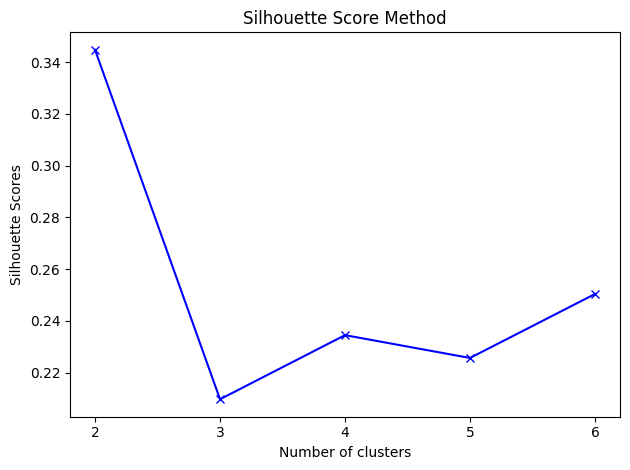

In [55]:
silhouette_scores = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=10, 
                random_state=42, 
                algorithm='lloyd')
    km.fit(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, km.labels_))

fig, ax = plt.subplots()
ax.plot(range(2, 7), silhouette_scores, 'bx-')
ax.set_title('Silhouette Score Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Scores')
plt.xticks(range(2, 7))
plt.tight_layout()
plt.show()

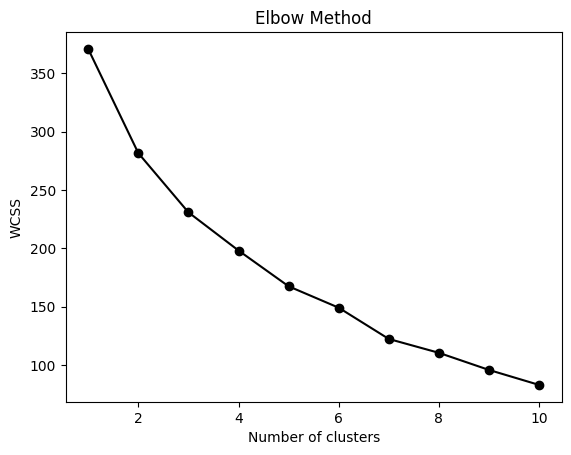

In [56]:
#Calculate WCSS for different values of k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
    
# Plot the elbow curve
plt.plot(range(1, 11), wcss, '-o', color='black')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


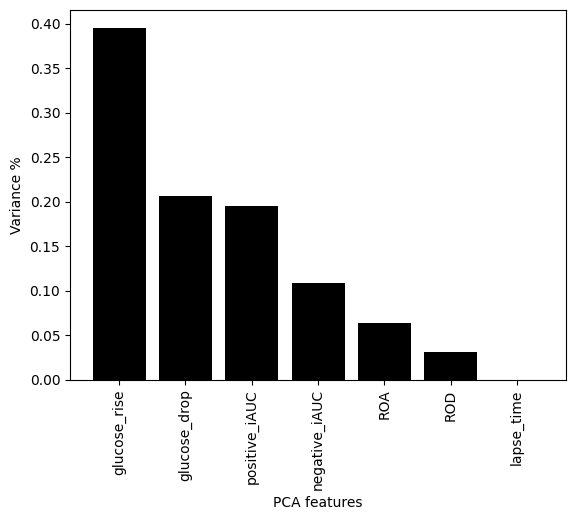

In [57]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(clustering_df)

# Create a PCA instance
pca = PCA(n_components=min(X_std.shape[0], X_std.shape[1]))  # Adjust the number of components if needed

# Perform PCA
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
feature_names = clustering_df.columns

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features, feature_names, rotation='vertical')
plt.show()

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [58]:
# Define the agglomerative clustering algorithm
agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0)

# Fit the model
agg_clustering.fit(scaled_data)

X_pd = pd.DataFrame(scaled_data)

# Group the data by cluster labels
groups = X_pd.groupby(agg_clustering.labels_)

# Calculate the mean or median of each feature within each group
means = groups.mean()
medians = groups.median()

# Print the mean or median of each feature within each group
print("Means:")
print(means)
print("Medians:")
print(medians)

Means:
           0         1         2         3         4         5         6
0   1.191598 -1.096231  0.657278  0.635826 -0.547283  0.297984 -0.904772
1   0.006774 -0.490277 -0.649062 -0.855994 -0.561589  0.743531  1.642179
2   0.042678 -1.862583  1.917782  0.666480  1.315570 -2.423142  1.730004
3  -1.178050  1.220649  1.528172  1.391955 -0.063184  1.582570 -1.168250
4  -1.016483  1.024606 -0.362584 -0.314443 -0.099576  1.466573 -0.992598
5  -1.321665 -1.078408  0.840624 -0.620981  0.889029 -2.262613  0.412616
6  -1.142146  1.398871 -1.359528 -1.060353  0.373430  1.165156 -0.641295
7   0.401716  0.365186 -1.244937 -0.672071 -1.152421  0.433143 -0.553469
8   0.437619 -0.026901 -0.809490 -0.488148 -0.594124  0.689498 -0.377817
9   0.904368 -0.383344 -0.328207  0.002313  1.777445 -0.660196  1.817830
10  0.024726  0.329542 -1.325151 -0.978610  1.189795 -0.227948  1.203049
11 -0.729253 -0.383344  0.645819 -0.058994 -0.540767 -0.108690  0.149138
12 -0.711301 -0.525922  0.473932 -0.283789 -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


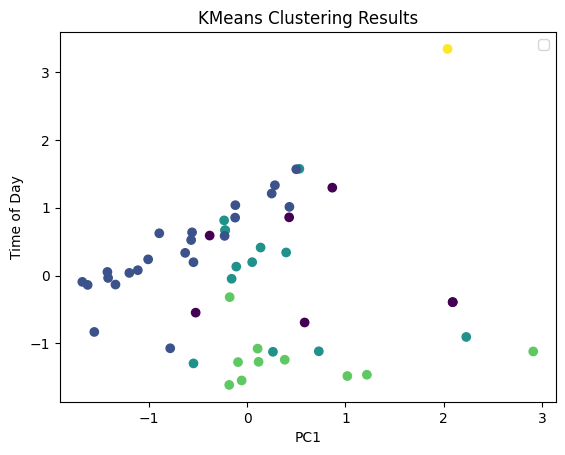

In [59]:
# Step 1: Separate the target variable from the features
target_variable = filtered_df['peak_time_of_day']

# Step 3: Apply PCA to the features data
pca = PCA(n_components=4, random_state=42)
pca_components = pca.fit_transform(scaled_data)

# Step 4: Concatenate the PCA components with the target variable
reshaped_target_variable = target_variable.values.reshape(-1, 1)
data = np.concatenate((pca_components, reshaped_target_variable), axis=1)

# Step 5: Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Step 6: Apply KMeans clustering to the concatenated data
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(data_scaled)

# Define the data source for the scatter plot
source = ColumnDataSource(data=dict(
    x=data_scaled[:, 0],
    y=data_scaled[:, 1],
    desc=df_events.index.tolist()
))

# Define the hover tooltip
hover = HoverTool(tooltips=[('event', '@desc')])

# Create the scatter plot
p = figure(title='KMeans Clustering Results', tools=[hover])
p.scatter('x', 'y', source=source)

# Show the scatter plot
show(p)

# Step 7: Plot the clustering results
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=kmeans.labels_)
plt.xlabel('PC1')
plt.ylabel('Time of Day')
plt.title('KMeans Clustering Results')
plt.legend()
plt.show()

In [60]:
from sklearn.inspection import permutation_importance

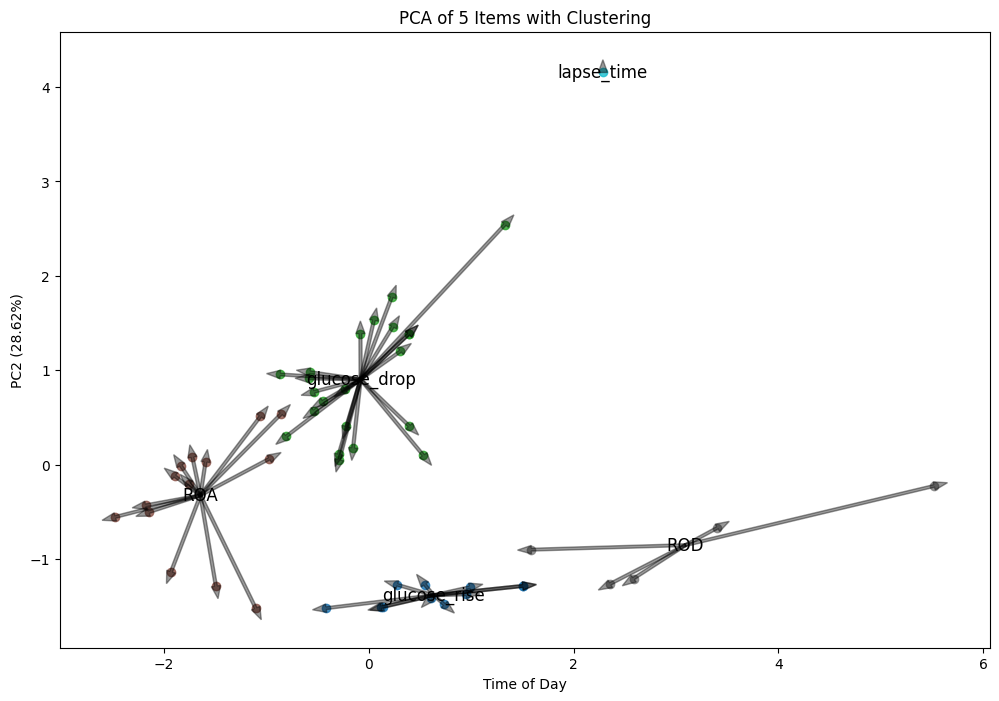

Silhouette Score: 0.2996417885471382


In [61]:
# Select the columns for clustering
columns_for_clustering = ['glucose_rise', 'glucose_drop', 'ROA', 'ROD', 'lapse_time']
# Separate the target variable from the features
target_variable = filtered_df['peak_time_of_day']

# Create a DataFrame with only the selected columns
df_scaled = filtered_df[columns_for_clustering].copy()

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_scaled)

# Perform PCA
pca = PCA(n_components=3, random_state=42)
X_r = pca.fit_transform(scaled_data)

# Perform clustering on the original data along with the target variable
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
predictions = kmeans.fit_predict(np.concatenate((scaled_data, target_variable.values.reshape(-1, 1)), axis=1))

plt.figure(figsize=(12, 8))
num_clusters = 5
colors = plt.cm.get_cmap('tab10', num_clusters)

# Create a dictionary to map cluster labels to cluster names
cluster_labels = {}
for i, column in enumerate(columns_for_clustering):
    cluster_labels[i] = column

for i in range(num_clusters):
    cluster_indices = np.where(predictions == i)[0]
    cluster_center = np.mean(X_r[cluster_indices, :], axis=0)  # Calculate the center of the cluster
    plt.scatter(X_r[cluster_indices, 0], X_r[cluster_indices, 1], color=colors(i), alpha=0.8)

    # Label the center of the cluster
    plt.annotate(cluster_labels[i], (cluster_center[0], cluster_center[1]), fontsize=12, color='black',
                 ha='center', va='center')

    # Add arrows to the data points
    for idx in cluster_indices:
        dx = X_r[idx, 0] - cluster_center[0]
        dy = X_r[idx, 1] - cluster_center[1]
        plt.arrow(cluster_center[0], cluster_center[1], dx, dy, color='black', alpha=0.4, width=0.03)

plt.xlabel('Time of Day')
plt.ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1] * 100))
plt.title('PCA of 5 Items with Clustering')
plt.show()

# Compute the Silhouette Score
silhouette_avg = silhouette_score(np.concatenate((scaled_data, target_variable.values.reshape(-1, 1)), axis=1), predictions)
print("Silhouette Score:", silhouette_avg)


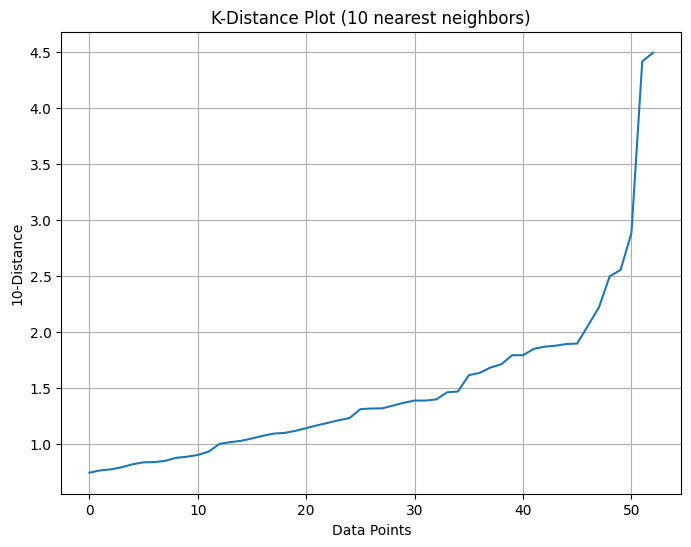

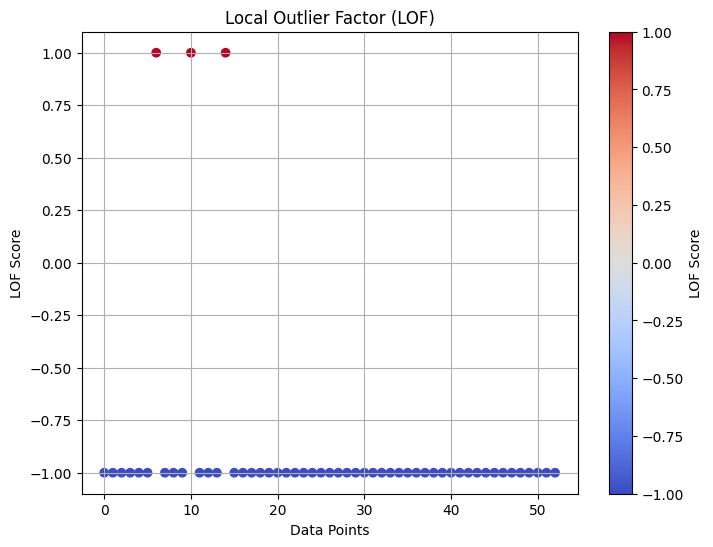

In [62]:
# Determine the best eps value using K distance plot and Local Outlier Factor

from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# Select the columns for clustering
columns_for_clustering = ['glucose_rise', 'glucose_drop', 'ROA', 'ROD', 'lapse_time']
# Separate the target variable from the features
target_variable = filtered_df['peak_time_of_day']

# Create a DataFrame with only the selected columns
df_scaled = filtered_df[columns_for_clustering].copy()

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_scaled)

# Calculate the k-distance plot
k = 10  # Choose the number of nearest neighbors
k_distances = NearestNeighbors(n_neighbors=k).fit(scaled_data).kneighbors()[0]
k_distances_mean = np.mean(k_distances, axis=1)

# Plotting the k-distance plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(scaled_data)), np.sort(k_distances_mean))
plt.xlabel('Data Points')
plt.ylabel(f'{k}-Distance')
plt.title(f'K-Distance Plot ({k} nearest neighbors)')
plt.grid(True)
plt.show()

# Calculate the Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=k, contamination='auto')
lof_scores = -lof.fit_predict(scaled_data)

# Plotting the LOF scores
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(scaled_data)), lof_scores, c=lof_scores, cmap='coolwarm')
plt.colorbar(label='LOF Score')
plt.xlabel('Data Points')
plt.ylabel('LOF Score')
plt.title('Local Outlier Factor (LOF)')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


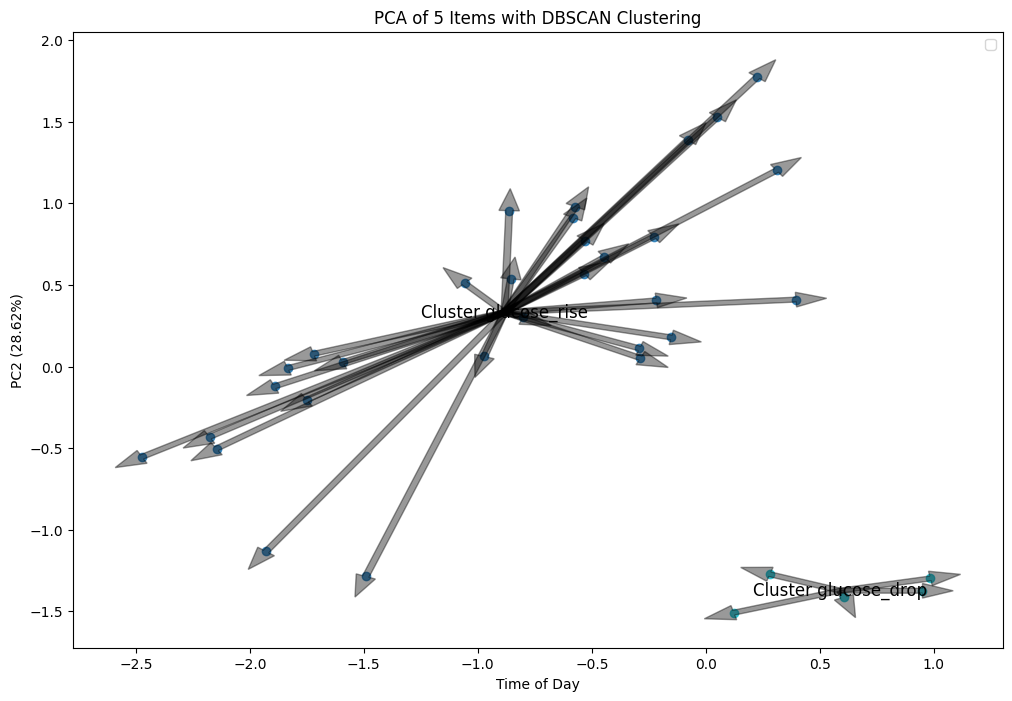

Silhouette Score: 0.17779218975817374


In [63]:
from sklearn.cluster import DBSCAN

# Select the columns for clustering
columns_for_clustering = ['glucose_rise', 'glucose_drop', 'ROA', 'ROD', 'lapse_time']
# Separate the target variable from the features
target_variable = filtered_df['peak_time_of_day']

# Create a DataFrame with only the selected columns
df_scaled = filtered_df[columns_for_clustering].copy()

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_scaled)

# Perform PCA
pca = PCA(n_components=4, random_state=42)
X_r = pca.fit_transform(scaled_data)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1, min_samples=5)  # Adjust the parameters as per your requirements
predictions = dbscan.fit_predict(X_r)

plt.figure(figsize=(12, 8))
num_clusters = len(np.unique(predictions)) - 1  # Excluding noise points
colors = plt.cm.get_cmap('tab10', num_clusters)

# Create a dictionary to map cluster labels to cluster names
cluster_labels = {}
for i, column in enumerate(columns_for_clustering):
    cluster_labels[i] = 'Cluster ' + column

# Handle noise points (label = -1)
cluster_labels[-1] = 'Noise'

for i in range(num_clusters):
    cluster_indices = np.where(predictions == i)[0]
    if i != -1:  # Exclude noise points from scatter plot
        cluster_center = np.mean(X_r[cluster_indices, :], axis=0)  # Calculate the center of the cluster
        plt.scatter(X_r[cluster_indices, 0], X_r[cluster_indices, 1], color=colors(i), alpha=0.8)

        # Label the center of the cluster
        plt.annotate(cluster_labels[i], (cluster_center[0], cluster_center[1]), fontsize=12, color='black',
                     ha='center', va='center')

        # Add arrows to the data points
        for idx in cluster_indices:
            dx = X_r[idx, 0] - cluster_center[0]
            dy = X_r[idx, 1] - cluster_center[1]
            plt.arrow(cluster_center[0], cluster_center[1], dx, dy, color='black', alpha=0.4, width=0.03)

    else:  # Plot noise points separately
        plt.scatter(X_r[cluster_indices, 0], X_r[cluster_indices, 1], color='gray', alpha=0.5, label=cluster_labels[i])

plt.xlabel('Time of Day')
plt.ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1] * 100))
plt.title('PCA of 5 Items with DBSCAN Clustering')
plt.legend()
plt.show()

# Compute the Silhouette Score (if applicable)
if num_clusters > 1:
    silhouette_avg = silhouette_score(X_r, predictions)
    print("Silhouette Score:", silhouette_avg)
else:
    print("Cannot compute Silhouette Score with a single cluster or noise only.")


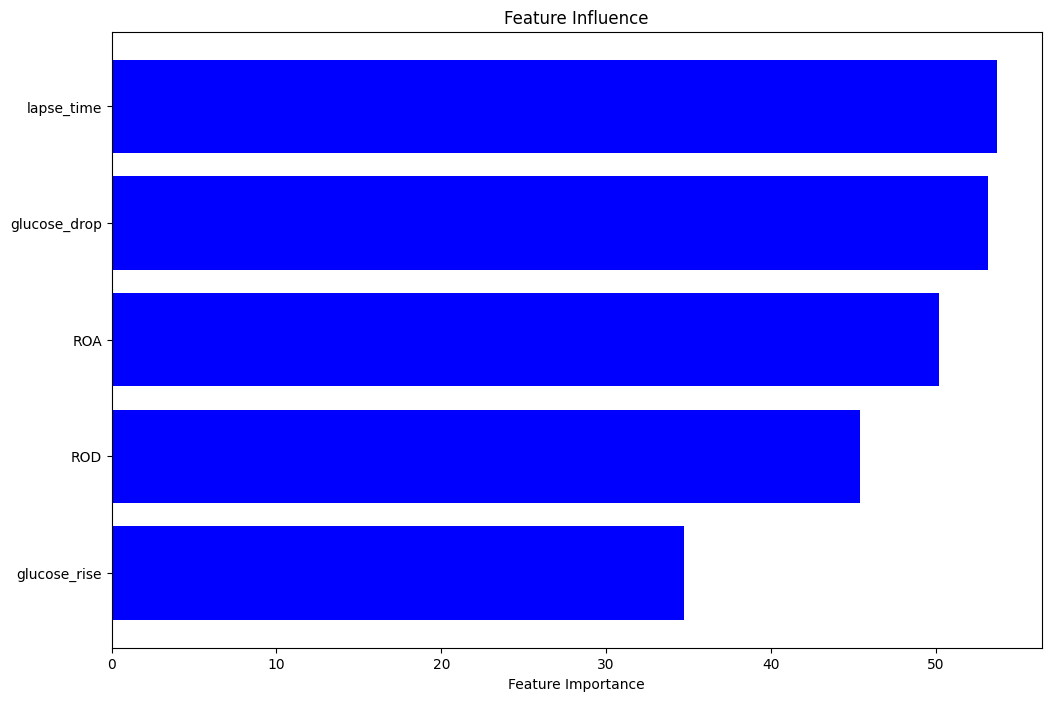

In [64]:
# Fit the clustering model
kmeans.fit(scaled_data)

# Compute feature importance
result = permutation_importance(kmeans, scaled_data, target_variable, random_state=0)

# Get feature importance scores and indices
feature_importance = result.importances_mean
feature_indices = np.argsort(feature_importance)

# Get the column names corresponding to the feature indices
feature_names = np.array(columns_for_clustering)[feature_indices][-len(columns_for_clustering):]

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(columns_for_clustering)), feature_importance[feature_indices][-len(columns_for_clustering):], color='b')
plt.yticks(range(len(columns_for_clustering)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Influence')
plt.show()

### Alternative method to group / 'cluster' glucose event parameters
1. 'Cluster' the glucose events based on the following set of rules
    * Rate of glucose appearance (ROA) / 
    * positive_iAUC (initial_nadir to peak)
    * Rate of glucose dissapearance (ROD)
    * negative_iAUC (peak to second_nadir)
    * Elapsed time between initial_nadir and secondary_nadir points (time_lapse)
    * Carb intake in time frame

In [65]:
import plotly.express as px
import plotly.graph_objects as go

In [66]:
# Select the columns that will be used for event comparison
selected_columns = ['peak_glucose', 'glucose_rise', 'glucose_drop', 'positive_iAUC', 
                    'negative_iAUC', 'ROA', 'ROD', 'lapse_time']

# Remove non-numeric values from selected columns
df_numeric = df_events[selected_columns].apply(pd.to_numeric, errors='coerce')

# Normalize the selected columns to have values between 0 and 1
normalized_df = (df_numeric - df_numeric.min()) / (df_numeric.max() - df_numeric.min())

# Define the number of bins for each column
num_bins = 5

# Perform binning for each column
binned_df = pd.DataFrame()
for column in normalized_df.columns:
    binned_df[column] = pd.cut(normalized_df[column], bins=num_bins, labels=False, duplicates='drop', include_lowest=True)

# Calculate the Euclidean distance between events
def calculate_distance(event1, event2):
    return np.sqrt(np.sum((event1 - event2) ** 2))

# Calculate the pairwise distances between all events
distances = np.zeros((len(df_events), len(df_events)))
for i in range(len(df_events)):
    for j in range(i+1, len(df_events)):
        distances[i, j] = calculate_distance(binned_df.iloc[i], binned_df.iloc[j])
        distances[j, i] = distances[i, j]

# Print the distances matrix
print(distances)

[[0.         1.73205081 1.73205081 ... 4.69041576 4.47213595 3.31662479]
 [1.73205081 0.         2.         ... 3.60555128 4.35889894 3.46410162]
 [1.73205081 2.         0.         ... 5.56776436 5.56776436 4.24264069]
 ...
 [4.69041576 3.60555128 5.56776436 ... 0.         3.74165739 4.35889894]
 [4.47213595 4.35889894 5.56776436 ... 3.74165739 0.         1.73205081]
 [3.31662479 3.46410162 4.24264069 ... 4.35889894 1.73205081 0.        ]]


In [67]:
# Select the columns that will be used for event comparison
selected_columns = ['peak_glucose', 'glucose_rise', 'glucose_drop', 'positive_iAUC', 'negative_iAUC', 'ROA', 'ROD', 'lapse_time']

# Remove non-numeric values from selected columns
df_numeric = df_events[selected_columns].apply(pd.to_numeric, errors='coerce')

# Normalize the selected columns to have values between 0 and 1
normalized_df = (df_numeric - df_numeric.min()) / (df_numeric.max() - df_numeric.min())

# Define the number of bins for each column
num_bins = 5

# Perform binning for each column
binned_df = pd.DataFrame()
for column in normalized_df.columns:
    binned_df[column] = pd.cut(normalized_df[column], bins=num_bins, labels=False, duplicates='drop', include_lowest=True)

# Calculate the Euclidean distance between events
def calculate_distance(event1, event2):
    return np.sqrt(np.sum((event1 - event2) ** 2))

# Calculate the pairwise distances between all events
distances = np.zeros((len(df_events), len(df_events)))
for i in range(len(df_events)):
    for j in range(i+1, len(df_events)):
        distances[i, j] = calculate_distance(binned_df.iloc[i], binned_df.iloc[j])
        distances[j, i] = distances[i, j]

# Print the distances matrix
print(distances)

# Define the specific peak_time_of_day value you want to consider
specific_time_of_day = 1

# Filter the DataFrame for the specific peak_time_of_day value
df_specific_time = df_events[df_events['peak_time_of_day'] == specific_time_of_day]

# Define the selected columns
selected_columns = ['peak_glucose', 'glucose_rise', 'glucose_drop', 'positive_iAUC', 'negative_iAUC', 'ROA', 'ROD', 'lapse_time']

# Define the bin edges for each clinical feature
bin_edges = {
    'peak_glucose': [150, 200, 250, 300, 350, 400, 450],
    'glucose_rise': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
    'glucose_drop': [-120, -110, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0],
    'positive_iAUC': [0, 1000, 2000, 3000],
    'negative_iAUC': [-3000, -2000, -1000, 0],
    'ROA': [0, 1, 2, 3],
    'ROD': [0, 1, 2, 3],
    'lapse_time': [0, 60, 90, 120, 180]
}

[[0.         1.73205081 1.73205081 ... 4.69041576 4.47213595 3.31662479]
 [1.73205081 0.         2.         ... 3.60555128 4.35889894 3.46410162]
 [1.73205081 2.         0.         ... 5.56776436 5.56776436 4.24264069]
 ...
 [4.69041576 3.60555128 5.56776436 ... 0.         3.74165739 4.35889894]
 [4.47213595 4.35889894 5.56776436 ... 3.74165739 0.         1.73205081]
 [3.31662479 3.46410162 4.24264069 ... 4.35889894 1.73205081 0.        ]]


In [68]:
# Create a copy of the filtered DataFrame
df_filtered = df_specific_time.copy()

In [69]:
# Group the data based on positive_iAUC using bins
positive_iAUC_bins = pd.cut(df_filtered['positive_iAUC'], bins=bin_edges['positive_iAUC'])
df_filtered['positive_iAUC_bins'] = positive_iAUC_bins

In [70]:
# Group the data based on ROA within each positive_iAUC bin
for positive_iAUC_bin in df_filtered['positive_iAUC_bins'].unique():
    relevant_data = df_filtered[df_filtered['positive_iAUC_bins'] == positive_iAUC_bin]
    roa_bins = pd.cut(relevant_data['ROA'], bins=bin_edges['ROA'])
    df_filtered.loc[relevant_data.index, 'ROA_bins'] = roa_bins


In [71]:
# Group the data based on glucose_rise within each positive_iAUC and ROA bin
for positive_iAUC_bin in df_filtered['positive_iAUC_bins'].unique():
    for roa_bin in df_filtered['ROA_bins'].unique():
        relevant_data = df_filtered[(df_filtered['positive_iAUC_bins'] == positive_iAUC_bin) & (df_filtered['ROA_bins'] == roa_bin)]
        glucose_rise_bins = pd.cut(relevant_data['glucose_rise'], bins=bin_edges['glucose_rise'])
        df_filtered.loc[relevant_data.index, 'glucose_rise_bins'] = glucose_rise_bins

In [72]:
# Generate clinically relevant bins
clinically_relevant_bins = []
for positive_iAUC_bin in df_filtered['positive_iAUC_bins'].unique():
    for roa_bin in df_filtered['ROA_bins'].unique():
        for glucose_rise_bin in df_filtered['glucose_rise_bins'].unique():
            relevant_bin = df_filtered[(df_filtered['positive_iAUC_bins'] == positive_iAUC_bin) &
                                       (df_filtered['ROA_bins'] == roa_bin) &
                                       (df_filtered['glucose_rise_bins'] == glucose_rise_bin)]
            if not relevant_bin.empty:
                clinically_relevant_bins.append(relevant_bin)

In [73]:
# Print the clinically relevant bins
for bin_df in clinically_relevant_bins:
    print(bin_df)

     initial_nadir_idx  initial_nadir_glucose  initial_nadir_time  \
3                    5                  171.0 2020-05-20 09:46:00   
96                   8                  118.0 2020-06-14 07:04:00   
160                  5                  121.0 2020-07-02 06:45:00   

     peak_glucose           peak_time  secondary_nadir_glucose  \
3           182.0 2020-05-20 09:56:00                     99.0   
96          135.0 2020-06-14 07:19:00                    118.0   
160         139.0 2020-07-02 07:00:00                    132.0   

    secondary_nadir_time  glucose_rise  glucose_drop  positive_iAUC  ...  \
3    2020-05-20 11:11:00          11.0         -83.0          882.5  ...   
96   2020-06-14 07:34:00          17.0         -17.0          632.5  ...   
160  2020-07-02 07:10:00          18.0          -7.0          650.0  ...   

     peak_to_secondary_nadir_time  lapse_time  carbs_g             meal_ts  \
3                            75.0        85.0     70.0 2020-05-23 09:50:00 

In [74]:
# Calculate the mean ad standard deviation of each of the features in the groups 

# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['positive_iAUC_bin', 'ROA_bin', 'glucose_rise_bin',
                                  'peak_glucose_mean', 'peak_glucose_std',
                                  'glucose_rise_mean', 'glucose_rise_std',
                                  'glucose_drop_mean', 'glucose_drop_std',
                                  'positive_iAUC_mean', 'positive_iAUC_std',
                                  'negative_iAUC_mean', 'negative_iAUC_std',
                                  'ROA_mean', 'ROA_std',
                                  'ROD_mean', 'ROD_std',
                                  'lapse_time_mean', 'lapse_time_std'])

# Calculate the mean and standard deviation for each bin
for bin_df in clinically_relevant_bins:
    positive_iAUC_bin = bin_df['positive_iAUC_bins'].iloc[0]
    ROA_bin = bin_df['ROA_bins'].iloc[0]
    glucose_rise_bin = bin_df['glucose_rise_bins'].iloc[0]

    peak_glucose_mean = bin_df['peak_glucose'].mean()
    peak_glucose_std = bin_df['peak_glucose'].std()

    glucose_rise_mean = bin_df['glucose_rise'].mean()
    glucose_rise_std = bin_df['glucose_rise'].std()

    glucose_drop_mean = bin_df['glucose_drop'].mean()
    glucose_drop_std = bin_df['glucose_drop'].std()

    positive_iAUC_mean = bin_df['positive_iAUC'].mean()
    positive_iAUC_std = bin_df['positive_iAUC'].std()

    negative_iAUC_mean = bin_df['negative_iAUC'].mean()
    negative_iAUC_std = bin_df['negative_iAUC'].std()

    ROA_mean = bin_df['ROA'].mean()
    ROA_std = bin_df['ROA'].std()

    ROD_mean = bin_df['ROD'].mean()
    ROD_std = bin_df['ROD'].std()

    lapse_time_mean = bin_df['lapse_time'].mean()
    lapse_time_std = bin_df['lapse_time'].std()

    # Create a DataFrame with the current bin's statistics
    bin_result_df = pd.DataFrame({'positive_iAUC_bin': [positive_iAUC_bin],
                                  'ROA_bin': [ROA_bin],
                                  'glucose_rise_bin': [glucose_rise_bin],
                                  'peak_glucose_mean': [peak_glucose_mean],
                                  'peak_glucose_std': [peak_glucose_std],
                                  'glucose_rise_mean': [glucose_rise_mean],
                                  'glucose_rise_std': [glucose_rise_std],
                                  'glucose_drop_mean': [glucose_drop_mean],
                                  'glucose_drop_std': [glucose_drop_std],
                                  'positive_iAUC_mean': [positive_iAUC_mean],
                                  'positive_iAUC_std': [positive_iAUC_std],
                                  'negative_iAUC_mean': [negative_iAUC_mean],
                                  'negative_iAUC_std': [negative_iAUC_std],
                                  'ROA_mean': [ROA_mean],
                                  'ROA_std': [ROA_std],
                                  'ROD_mean': [ROD_mean],
                                  'ROD_std': [ROD_std],
                                  'lapse_time_mean': [lapse_time_mean],
                                  'lapse_time_std': [lapse_time_std]})
    # Concatenate the current bin's statistics with the overall result DataFrame
    result_df = pd.concat([result_df, bin_result_df], ignore_index=True)

# Print the resulting DataFrame
print(result_df)

  positive_iAUC_bin ROA_bin glucose_rise_bin  peak_glucose_mean  \
0         (0, 1000]  (1, 2]         (10, 20]              152.0   
1         (0, 1000]  (1, 2]         (70, 80]              160.5   
2         (0, 1000]  (1, 2]         (30, 40]              152.0   
3         (0, 1000]  (1, 2]       (110, 120]              225.0   
4         (0, 1000]  (1, 2]       (100, 110]              201.0   
5         (0, 1000]  (1, 2]         (80, 90]              173.0   
6         (0, 1000]  (0, 1]         (10, 20]              139.5   
7         (0, 1000]  (0, 1]         (50, 60]              165.0   
8         (0, 1000]  (0, 1]          (0, 10]              194.0   
9      (1000, 2000]  (1, 2]         (80, 90]              279.0   

   peak_glucose_std  glucose_rise_mean  glucose_rise_std  glucose_drop_mean  \
0         26.057629          15.333333          3.785939         -35.666668   
1         33.234020          76.500000          4.949748         -62.500000   
2               NaN      

In [75]:
# Define the bin edges for each column
bin_edges = {}
for column in normalized_df.columns:
    min_val = df_numeric[column].min()
    max_val = df_numeric[column].max()
    edges = np.linspace(min_val, max_val, num=num_bins+1)
    bin_edges[column] = edges

# Revert the bin values back to blood glucose values
reverted_df = pd.DataFrame()
for column in binned_df.columns:
    bin_values = binned_df[column]
    column_edges = bin_edges[column]
    glucose_values = [column_edges[value] for value in bin_values]
    reverted_df[column] = glucose_values

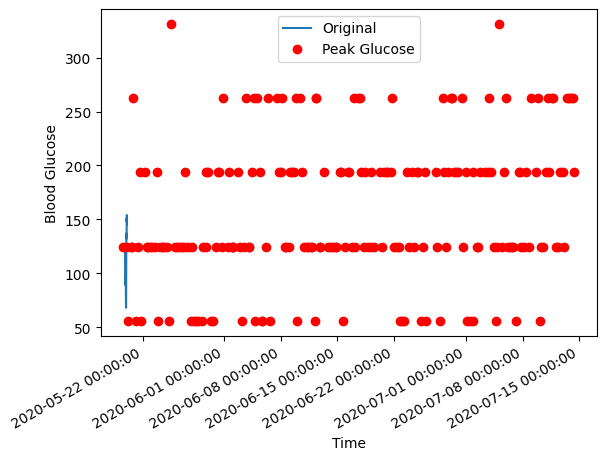

In [76]:
# Plot the reverted glucose values
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(glucose_ts_sliced_, glucose_value_sliced_, label='Original')
ax.plot(df_events['peak_time'], reverted_df['peak_glucose'], 'ro', label='Peak Glucose')

# Check if 'initial_nadir_glucose' column exists in reverted_df
if 'initial_nadir_glucose' in reverted_df.columns:
    ax.plot(df_events['initial_nadir_time'], reverted_df['initial_nadir_glucose'], 'go', label='Initial Nadir')

# Check if 'secondary_nadir_glucose' column exists in reverted_df
if 'secondary_nadir_glucose' in reverted_df.columns:
    ax.plot(df_events['secondary_nadir_time'], reverted_df['secondary_nadir_glucose'], 'yo', label='Secondary Nadir')

ax.set_xlabel('Time')
ax.set_ylabel('Blood Glucose')
ax.legend()

fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(fmt)

fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')

plt.show()

/var/folders/9p/vwhkd5c50_j5cz3cyj0q4qsh0000gp/T/ipykernel_36526/845072723.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(pad=2.0)


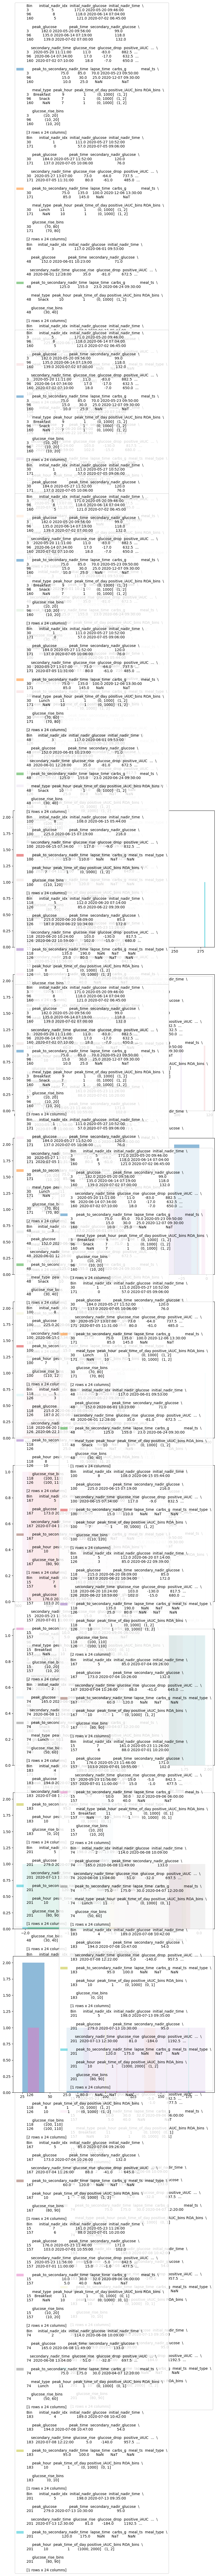

In [77]:
# Define the clinical features to visualize
features_to_visualize = ['peak_glucose', 'glucose_rise', 'glucose_drop', 'positive_iAUC', 'negative_iAUC', 'ROA', 'ROD', 'lapse_time']

# Calculate the number of rows and columns for subplots
num_features = len(features_to_visualize)
num_cols = 1
num_rows = (num_features + num_cols - 1) // num_cols

# Create subplots for each clinical feature
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8 * num_rows))

# Flatten the axes array if necessary
if num_rows > 1:
    axes = axes.flatten()

# Iterate over each clinical feature and plot histograms for each clinically relevant bin
for i, feature in enumerate(features_to_visualize):
    ax = axes[i]
    ax.set_title(f'{feature} Distribution')

    # Iterate over each clinically relevant bin
    for bin_df in clinically_relevant_bins:
        # Get the data within the bin for the current feature
        data = bin_df[feature]

        # Plot a histogram for the data within the bin
        ax.hist(data, bins='auto', alpha=0.5, label=f'Bin {bin_df}')

    ax.legend()

plt.tight_layout(pad=2.0)
plt.show()

In [78]:
# Create a new column for the bin labels
df_events['bin_label'] = time_bins

# Create a dictionary to map bin labels to time intervals
bin_mapping = {
    1: range(6, 12),     # morning: 6am to 11:59am
    2: range(12, 18),    # afternoon: 12pm to 5:59pm
    3: range(18, 24),    # evening: 6pm to 11:59pm
    4: range(0, 6)       # overnight: 12am to 5:59am
}

# Create a new column for the bin time intervals
df_events['bin_time_interval'] = df_events['bin_label'].map(bin_mapping)

# Create a new column for the bin blood glucose values
def get_bin_glucose(row):
    time_interval = row['bin_time_interval']
    return [glucose_segment[i] for i in time_interval]

df_events['bin_glucose_values'] = df_events.apply(get_bin_glucose, axis=1)


ValueError: setting an array element with a sequence

In [ ]:
# Create the x-axis values (time intervals)
x_values = df_events['bin_time_interval'].apply(lambda x: glucose_segment_ts[x[0]])

# Create the y-axis values (bin blood glucose values)
y_values = df_events['bin_glucose_values']

# Plot the blood glucose values
for i, y in enumerate(y_values):
    x = x_values[i]
    ax1.plot(x, y, label=f"Bin {i+1}")

# Set the x-axis labels and ticks
ax1.set_xlabel('Time')
ax1.set_xticks(x_values)
ax1.set_xticklabels([x.strftime('%Y-%m-%d %H:%M:%S') for x in x_values], rotation=30)

# Add a legend
ax1.legend()
